In [1]:
import keras
keras.__version__
from pylab import *
plt.rc('font',family='Times New Roman')#全局改成Times New Roman||

import os
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data_dir = 'D:\Load预测'
fname = os.path.join(data_dir, 'data(去除两个变量).csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:69714]  #43801

print(header)
print(len(lines))

D:\TAO2018\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['time', 'load', 'T1', 'T2', 'T3', 'T4', 'weekday', 'timeofday', 'yest.load', 'last.hour.load', 'last.week.load', 'yest.mean', 'yest.min', 'EMA12', 'EMA24', 'EMA48', 'EMA168', 'Target']
69713


In [2]:
import numpy as np

float_data_qian = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data_qian[i, :] = values

float_data_qian.shape

(69713, 17)

No handles with labels found to put in legend.


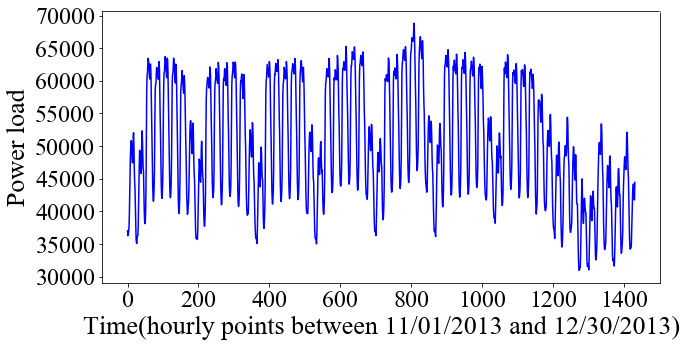

In [3]:
from matplotlib import pyplot as plt

load = float_data_qian[:, 16]  



plt.figure(figsize=(10,5))

#调整坐标轴刻度的大小
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.plot(load[68281:69713], 'b')
#plt.plot(load, 'b')
#plt.plot(load[:68281], 'k')



# 设置图表标题并给坐标轴加上标签
#plt.xlabel("Time(hourly points between 01/08/2006 and 12/30/2013)",fontsize=26)
plt.xlabel("Time(hourly points between 11/01/2013 and 12/30/2013)",fontsize=26)
plt.ylabel("Power load",fontsize=26)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=0)
#plt.savefig('负荷变化周特性0723.pdf', bbox_inches='tight')
plt.show()



# 分析周期性:年、月、周、天

<function matplotlib.pyplot.show(*args, **kw)>

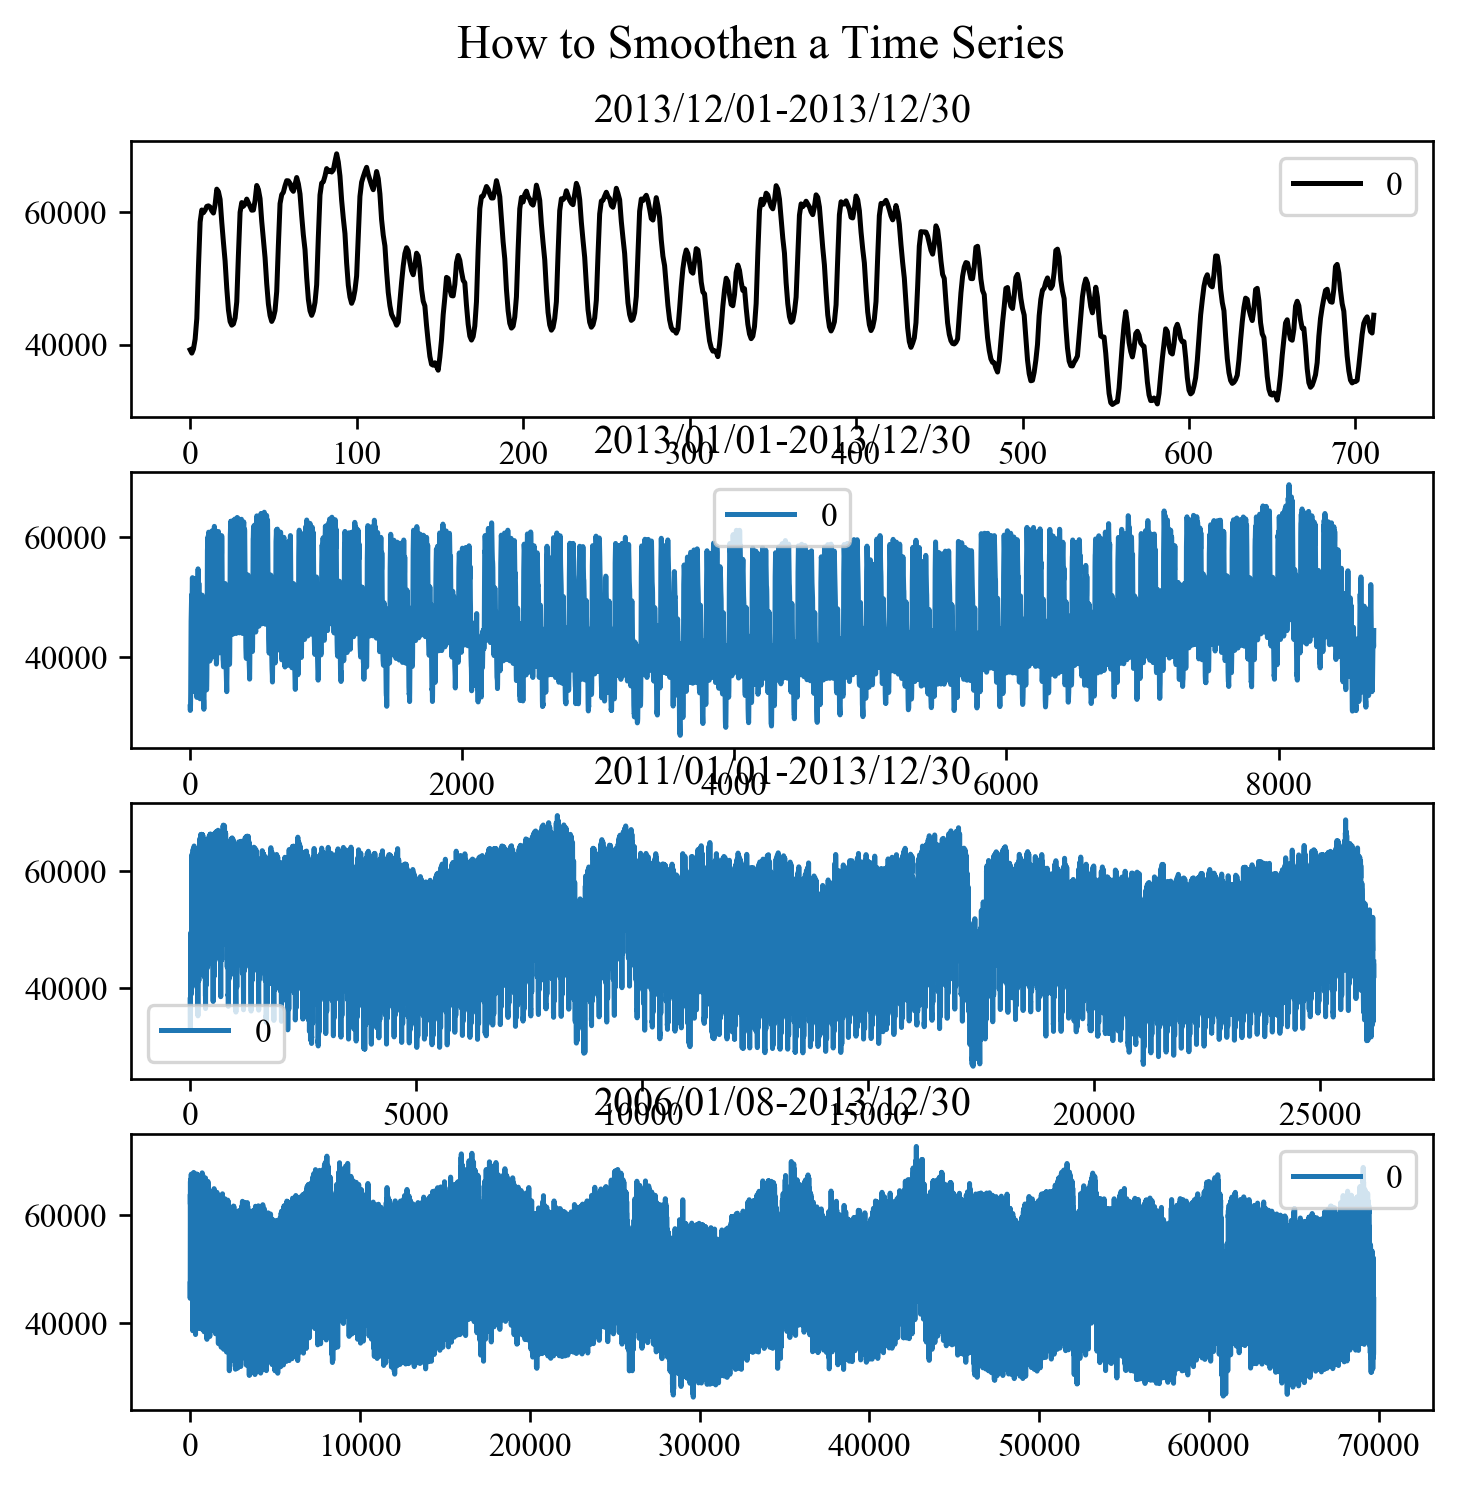

In [4]:
# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=False, dpi=240)
#plt.plot(load[69001:69713], 'k', title='2013/12/01-2013/12/30')#一个月 label='True value'   2011年到2013年全部的[43522:69713]
#plt.plot(load[61012:69713], 'k', title='2013/01/01-2013/12/30')#, label='True value'   2011年到2013年全部的[43522:69713]
#plt.plot(load[43522:69713], 'k', title='2011/01/01-2013/12/30')#, label='True value'   2011年到2013年全部的[43522:69713]
#plt.plot(load, 'k', title='2006/01/08-2013/12/30')#, label='True value'   2011年到2013年全部的[43522:69713]

x1 = pd.DataFrame(load[69001:69713])
x2 = pd.DataFrame(load[61012:69713])
x3 = pd.DataFrame(load[43522:69713])
x4 = pd.DataFrame(load)

x1.plot(ax=axes[0], color='k', title='2013/12/01-2013/12/30')
x2.plot(ax=axes[1], title='2013/01/01-2013/12/30')
x3.plot(ax=axes[2], title='2011/01/01-2013/12/30')
x4.plot(ax=axes[3],  title='2006/01/08-2013/12/30')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show

# HM模型

In [5]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))
def errors(y_true, y_pred): 
    target = y_true
    prediction = y_pred

    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    #print("Errors: ", error)
    #print(error)

    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)#target-prediction之差平方 
        absError.append(abs(val))#误差绝对值

    #print("Square Error: ", squaredError)
    #print("Absolute Value of Error: ", absError)

    print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE


    from math import sqrt
    print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
    print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

    
    
x1=float_data_qian[:, 0]
x2=float_data_qian[:, 16]
print('MAPE:', mean_absolute_percentage_error(x1, x2))
print('SMAPE:', smape(x1, x2))
errors(x1, x2)

MAPE: 8.960592482608764
SMAPE: 0.08615409088133841
MSE =  41006788.62116989
RMSE =  6403.654317744665
MAE =  4138.315154131941


# 深度学习方法

In [4]:
mean = float_data_qian[:60953].mean(axis=0)
float_data =float_data_qian- mean
std = float_data_qian[:60953].std(axis=0)
float_data = float_data/std

load_xiao = float_data[:, 16] 

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][16]   #===================目标是24小时后的数据===================
        samples_without_target =  samples[:,:data.shape[-1]-1]  #========把target从样本中去掉 
        yield samples_without_target, targets

In [6]:
lookback = 2#过去5天
step = 1     #每1小时一个采样点
delay = 0    #预测25小时之后
batch_size = 50

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=48762,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=48763,
                    max_index=60953,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=60954,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (60953 - 48763 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 60954 - lookback) // batch_size
print('测试集抽取次数：',test_steps)
print('验证集抽取次数：',val_steps)

测试集抽取次数： 175
验证集抽取次数： 243


In [7]:
for data_batch,labels_batch in test_gen:
    print('data_batch shape',data_batch.shape)
    print('labels_batch shape',labels_batch.shape)
    break
#print(train_gen.shape)

data_batch shape (50, 2, 17)
labels_batch shape (50,)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
'''回调函数'''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='负荷预测.model',#============保存最佳模型
        monitor='val_loss',
        save_best_only=True,
    ),
  
    keras.callbacks.ReduceLROnPlateau(   #============降低学习率
        monitor='val_loss',
        factor=0.1,
        patience=5,
    ),
    keras.callbacks.EarlyStopping(   #============EarlyStopping
        monitor='mse',
        patience=10,
    ),
    keras.callbacks.CSVLogger('训练结果0712.csv', separator=',', append=False)
 
  
]
model = Sequential()
model.add(layers.LSTM(300, return_sequences = True,input_shape=(None, float_data.shape[-1])))# 
#model.add(layers.Dropout(0.2))
model.add(layers.LSTM(300, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1))

#=============================================================CCC的
#model2 = Sequential()
#model2.add(layers.GRU(300, return_sequences=True,input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
#model2.add(layers.GRU(300, dropout=0.4,recurrent_dropout=0.4,activation='relu'))
#model2.add(Dense(16, activation="relu"))
#model2.add(Dense(1))
#model2.compile(loss='mae', optimizer='adam',metrics=['mse','mape'])
#==============================================================

model.compile(loss='mae', optimizer='adam',metrics=['mse','mape'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=900,
                              epochs=40,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
model.save('负荷LSTM.model')

In [ ]:
#history.history   #查看模型返回参数
print('01 train_mae：',history.history['loss'][-1])
print('02 val_mae：',history.history['val_loss'][-1])
print('03 train_mse：',history.history['mean_squared_error'][-1])
print('04 val_mse:',history.history['val_mean_squared_error'][-1])
print(' train_mape：',history.history['mean_absolute_percentage_error'][-1])
print(' val_mape：',history.history['val_mean_absolute_percentage_error'][-1])
test_loss,test_mae,test_mape = model.evaluate_generator(test_gen, 174)
print('05 test_mae:',test_loss)
print('06 test_mse:',test_mae)
print('06 test_mape:',test_mape)
print('07 lr:',history.history['lr'][-1])

In [ ]:
model.metrics_names   #查看评价指标的名字

#history.history

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(len(loss))
#画评价指标
plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
#画损失指标
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

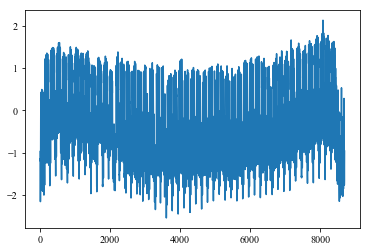

预测总长度 8700


In [8]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



from keras.models import load_model
perdict_model = load_model('负荷预测.model')
perdict_model.summary

pre_power = perdict_model.predict_generator(test_gen, steps = 174, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
plt.plot(pre_power)
plt.show()
print('预测总长度',len(pre_power))

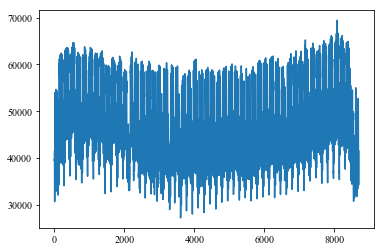

In [9]:
#***********************************还原数据******************************************#
pre_power=pre_power * std[16]
pre_power=pre_power + mean[16]
plt.plot(pre_power)
plt.show()

# 求误差

In [10]:
#norm_temp = float_data[:, 1]  
#nttt = norm_temp[38000+68:43700+68]
ttt = load[60953+53:69653+50+3]   #load = float_data_qian[:, 18]  #    加上一个batch size  再加一个滞后 delay +lookback


target = ttt
prediction = pre_power   #8700个点

def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

error = []
for i in range(len(target)):
    error.append(target[i] - prediction[i])
  
#print("Errors: ", error)
#print(error)
  
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)#target-prediction之差平方 
    absError.append(abs(val))#误差绝对值
 
#print("Square Error: ", squaredError)
#print("Absolute Value of Error: ", absError)
 
print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE
 
 
from math import sqrt
print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

print("MAPE = ", mean_absolute_percentage_error(target, prediction))#平均绝对误差MAE
print("SMAPE = ", smape(target, prediction))#平均绝对误差MAE

MSE =  268201.87218390807
RMSE =  517.8821025908388
MAE =  364.32206896551725
MAPE =  21.89023592298876
SMAPE =  0.21178089129776256


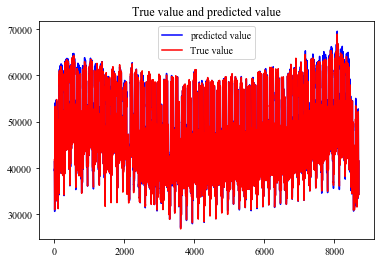

In [11]:
import matplotlib.pyplot as plt
steps = range(len(pre_power))
plt.figure()
plt.plot(pre_power, 'b', label='predicted value')
plt.plot(ttt, 'r', label='True value')  

plt.title('True value and predicted value')
plt.legend()

plt.show()

In [ ]:
import numpy  
numpy.savetxt('真实值.csv', ttt, delimiter = ',')

In [12]:
import numpy  
numpy.savetxt('预测值.csv', pre_power, delimiter = ',')